# Week 2: Ingest and Explore the Dataset

In [ ]:
!git clone https://github.com/zhaoyangLin1008/test.git
%cd test/Notebooks
!ls ../Data


Cloning into 'test'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 166 (delta 56), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (166/166), 1.91 MiB | 4.19 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/test/Notebooks
 cpi		        dividends      unemployment_msa_m_20250826.csv
 dgs10_m_20250826.csv  'stock price'


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from IPython.display import display

In [ ]:
# Data import
DATA_DIR = Path("../Data")
OUT_DIR  = Path("../Reports/w2_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# raw dataset Overlook
def try_infer_date_column(df):
    """Guess a date column from common names or by parsing"""
    candidates = ["date", "Date", "DATE", "observation_date", "Ex-Date", "ex_date"]
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: try parsing each column
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c].head(30), errors="coerce")
            if parsed.notna().mean() > 0.6:
                return c
        except Exception:
            pass
    return None

csv_files = sorted([p for p in DATA_DIR.glob("*.csv")])
if not csv_files:
    print("[WARN] No CSV files found in /content. Please upload your data files.")
else:
    overview_rows = []
    for path in csv_files:
        df = pd.read_csv(path)

        # basic info
        nrows, ncols = df.shape
        dcol = try_infer_date_column(df)

        # check date range
        date_min, date_max = None, None
        if dcol is not None:
            dt = pd.to_datetime(df[dcol], errors="coerce")
            if dt.notna().any():
                date_min = str(dt.min().date())
                date_max = str(dt.max().date())

        num_cols = df.select_dtypes(include=[np.number]).shape[1]
        non_num_cols = ncols - num_cols

        # save a small sample for reference
        df.head(10).to_csv(OUT_DIR / f"sample__{path.stem}.csv", index=False)

        overview_rows.append({
            "filename": path.name,
            "rows": nrows,
            "cols": ncols,
            "date_col": dcol,
            "date_min": date_min,
            "date_max": date_max,
            "numeric_cols": num_cols,
            "non_numeric_cols": non_num_cols,
            "columns_preview": ", ".join(map(str, df.columns[:6]))
        })

        print(f"[CHECK] {path.name}: shape={df.shape}, "
              f"date_col={dcol}, date_range=({date_min}, {date_max})")

    # build overview table
    overview = pd.DataFrame(overview_rows).sort_values("filename").reset_index(drop=True)
    overview.to_csv(OUT_DIR / "files_overview.csv", index=False)

    # show as a table in notebook
    display(overview.head())
    print("\nOverview saved to:", OUT_DIR / "files_overview.csv")


[CHECK] dgs10_m_20250826.csv: shape=(764, 3), date_col=date, date_range=(1962-01-31, 2025-08-31)
[CHECK] unemployment_msa_m_20250826.csv: shape=(2550, 4), date_col=date, date_range=(1990-01-01, 2025-06-01)


,filename,rows,cols,date_col,date_min,date_max,numeric_cols,non_numeric_cols,columns_preview
0,dgs10_m_20250826.csv,764,3,date,1962-01-31,2025-08-31,1,2,"date, series_id, value"
1,unemployment_msa_m_20250826.csv,2550,4,date,1990-01-01,2025-06-01,1,3,"date, series_id, value, city"



Overview saved to: ../Reports/w2_out/files_overview.csv


In [ ]:
# Data basic standardization and simple engineer features
#covert data to monthly
def to_month_end(s):
    """Convert date to month-end date"""
    dt = pd.to_datetime(s, errors="coerce")
    return (dt + pd.offsets.MonthEnd(0)).dt.normalize()

#calculate the fluctuation of month to month
def level_diff(s, periods=1):
    """Month-to-month difference"""
    return s.diff(periods=periods)

#take the last price in a month
def mon_agg_last(x):
    """Get the last available value in a month"""
    return x.dropna().iloc[-1] if x.notna().any() else np.nan

#convert the stock price to monthly
def month_end_close(price_df, date_col="Date", close_col="Close"):
    tmp = price_df.copy()
    tmp[date_col] = to_month_end(tmp[date_col])
    tmp[close_col] = pd.to_numeric(tmp[close_col], errors="coerce")
    out = (tmp.groupby(date_col, as_index=False)[close_col]
              .agg(mon_agg_last)
              .rename(columns={date_col: "date", close_col: "adj_price"}))
    return out
#claculate monthly dividents
def monthly_sum_by_exdate(div_df, date_col="Ex-Date", amt_col="Amount"):
    tmp = div_df.copy()
    tmp[date_col] = to_month_end(tmp[date_col])
    tmp[amt_col] = pd.to_numeric(tmp[amt_col], errors="coerce")
    out = (tmp.groupby(date_col, as_index=False)[amt_col]
              .sum()
              .rename(columns={date_col: "date", amt_col: "dividend"}))
    return out
# divident of a year
def compute_ttm_dividend(div_monthly):
    s = div_monthly.sort_values("date")["dividend"].fillna(0.0)
    return s.rolling(window=12, min_periods=1).sum()


In [ ]:
# map the company and city
COMPANY_TO_METRO = {
    "BXP":  "Boston",
    "SLG":  "New York",
    "ELME": "Washington",
    "EQR":  "Chicago",
    "REXR": "Los Angeles",
    "TRNO": "Miami",
}

# the dividents and price of company
COMPANY_FILES = {
    "BXP":  ("stock price/bxp_prices.csv",  "dividends/bxp_dividends.csv"),
    "ELME": ("stock price/elme_prices.csv", "dividends/elme_dividends.csv"),
    "EQR":  ("stock price/eqr_prices.csv",  "dividends/eqr_dividends.csv"),
    "REXR": ("stock price/rexr_prices.csv", "dividends/rexr_dividends.csv"),
    "SLG":  ("stock price/slg_prices.csv",  "dividends/slg_dividends.csv"),
    "TRNO": ("stock price/trno_prices.csv", "dividends/trno_dividends.csv"),
}

In [ ]:
#Data cleaning
#First aspect --- Firms' data (price and dividents)
company_tables = []
for tic, (price_file, div_file) in COMPANY_FILES.items():
  #read the raw data
    px_raw = pd.read_csv(DATA_DIR / price_file)
    dv_raw = pd.read_csv(DATA_DIR / div_file)
    print(f"[{tic}] raw shapes -> prices={px_raw.shape}, dividends={dv_raw.shape}")

    # git rid of same rows
    px = px_raw.drop_duplicates().copy()
    dv = dv_raw.drop_duplicates().copy()
    # standardize time
    px["Date"] = pd.to_datetime(px["Date"], errors="coerce")
    dv["Ex-Date"] = pd.to_datetime(dv["Ex-Date"], errors="coerce")
    #transfer numbers to folat and non numbers to NAN
    px["Close"] = pd.to_numeric(px["Close"], errors="coerce")
    dv["Amount"] = pd.to_numeric(dv["Amount"], errors="coerce")
    #Get rid of NANs
    px = px[px["Date"].notna() & px["Close"].notna()]
    dv = dv[dv["Ex-Date"].notna() & dv["Amount"].notna()]

    # monthly level
    px_m = month_end_close(px)
    dv_m = monthly_sum_by_exdate(dv)

    #take the same time period
    if not dv_m.empty and not px_m.empty:
     min_date = max(px_m["date"].min(), dv_m["date"].min())
     max_date = min(px_m["date"].max(), dv_m["date"].max())
     px_m = px_m[(px_m["date"] >= min_date) & (px_m["date"] <= max_date)]
     dv_m = dv_m[(dv_m["date"] >= min_date) & (dv_m["date"] <= max_date)]

    # merge and claculate TTM
    cur = (pd.merge(px_m, dv_m, on="date", how="left")
             .sort_values("date")
             .assign(dividend=lambda d: d["dividend"].fillna(0.0)))
    cur["dividend_ttm"] = compute_ttm_dividend(cur)
    cur["company"] = tic

    print(f"[{tic}] monthly rows={cur.shape[0]}, "
          f"range=({cur['date'].min().date()}, {cur['date'].max().date()})")

    company_tables.append(cur[["date","company","adj_price","dividend","dividend_ttm"]])

all_companies = pd.concat(company_tables, ignore_index=True)
all_companies.to_csv(OUT_DIR / "step2_company_monthly_all.csv", index=False)
print("[all_companies] shape:", all_companies.shape)
display(all_companies.head(20))


[BXP] raw shapes -> prices=(247, 6), dividends=(55, 3)
[BXP] monthly rows=127, range=(2014-12-31, 2025-06-30)
[ELME] raw shapes -> prices=(247, 6), dividends=(55, 3)
[ELME] monthly rows=128, range=(2015-01-31, 2025-08-31)
[EQR] raw shapes -> prices=(385, 6), dividends=(55, 3)
[EQR] monthly rows=127, range=(2014-12-31, 2025-06-30)
[REXR] raw shapes -> prices=(146, 6), dividends=(55, 3)
[REXR] monthly rows=129, range=(2014-12-31, 2025-08-31)
[SLG] raw shapes -> prices=(247, 6), dividends=(98, 3)
[SLG] monthly rows=129, range=(2014-12-31, 2025-08-31)
[TRNO] raw shapes -> prices=(187, 6), dividends=(55, 3)
[TRNO] monthly rows=129, range=(2014-12-31, 2025-08-31)
[all_companies] shape: (769, 5)


,date,company,adj_price,dividend,dividend_ttm
0,2014-12-31,BXP,100.7570,5.80,5.80
1,2015-01-31,BXP,108.6960,7.75,13.55
2,2015-02-28,BXP,107.6030,0.00,13.55
3,2015-03-31,BXP,110.5230,0.65,14.20
4,2015-04-30,BXP,104.0960,0.00,14.20
5,2015-05-31,BXP,102.2990,0.00,14.20
6,2015-06-30,BXP,95.7034,0.65,14.85
7,2015-07-31,BXP,97.5042,0.00,14.85
8,2015-08-31,BXP,89.6563,0.00,14.85
9,2015-09-30,BXP,94.1603,0.65,15.50


In [ ]:
#Data cleaning
#Second aspect --- CPI and umemployment
#CPI
CPI_FILES = {
    "Boston":      "cpi/la_cpi_boston.csv",
    "Chicago":     "cpi/la_cpi_chicago.csv",
    "Los Angeles": "cpi/la_cpi_los_angeles.csv",
    "Miami":       "cpi/la_cpi_miami.csv",
    "New York":    "cpi/la_cpi_ny.csv",
    "Washington":  "cpi/la_cpi_Washington.csv",
}
cpi_tables = []

for city, fname in CPI_FILES.items():
    path = DATA_DIR / fname
    if not path.exists():
        print(f"[WARN] Missing CPI file for {city}")
        continue

    df = pd.read_csv(path)
    if "date" in df.columns:
        dcol = "date"
    elif "DATE" in df.columns:
        dcol = "DATE"
    elif "observation_date" in df.columns:
        dcol = "observation_date"
    else:
        dcol = df.columns[0]

    vcol = "value" if "value" in df.columns else df.columns[-1]

    df = df[[dcol, vcol]].rename(columns={dcol:"date", vcol:"cpi"})
    df["date"] = to_month_end(df["date"])
    df["cpi"]  = pd.to_numeric(df["cpi"], errors="coerce")
    df = df[df["date"].notna() & df["cpi"].notna()].drop_duplicates()
    df = df.sort_values("date")

    # engineer features
    df["cpi_yoy"] = df["cpi"]/df["cpi"].shift(12) - 1
    df["cpi_mom"] = df["cpi"]/df["cpi"].shift(1)  - 1
    df["metro"]   = city

    cpi_tables.append(df[["date","metro","cpi","cpi_yoy","cpi_mom"]])

# merge all COI
cpi_all = pd.concat(cpi_tables, ignore_index=True) if cpi_tables else pd.DataFrame()
cpi_all.to_csv(OUT_DIR / "step3_cpi_all.csv", index=False)

print("CPI total shape:", cpi_all.shape)
display(cpi_all.head(10))

#Unemployment
unemp_path = DATA_DIR / "unemployment_msa_m_20250826.csv"
if not unemp_path.exists():
    print("[WARN] Unemployment file missing")
    unemp = pd.DataFrame(columns=["metro","date","unemp","unemp_mom"])
else:
    df = pd.read_csv(unemp_path)

    # standardize date and time
    df["date"]  = to_month_end(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df[df["date"].notna() & df["value"].notna()].drop_duplicates()

    # metro data to the city
    df["metro"] = None
    for city in set(COMPANY_TO_METRO.values()):
        df.loc[df["city"].str.contains(city, na=False), "metro"] = city
    df = df.dropna(subset=["metro"])

    # take average to month
    unemp = (df.groupby(["metro","date"], as_index=False)["value"]
               .mean()
               .rename(columns={"value":"unemp"}))
    # month to month and year to year data
    unemp = unemp.sort_values(["metro","date"])
    unemp["unemp_mom"] = unemp.groupby("metro")["unemp"].transform(level_diff)

unemp.to_csv(OUT_DIR / "step4_unemployment_all.csv", index=False)

print("Unemployment shape:", unemp.shape)
display(unemp.head(10))


CPI total shape: (4004, 5)


,date,metro,cpi,cpi_yoy,cpi_mom
0,1914-12-31,Boston,10.5,NaN,NaN
1,1915-12-31,Boston,10.7,NaN,0.019048
2,1916-12-31,Boston,12.1,NaN,0.130841
3,1917-12-31,Boston,14.2,NaN,0.173554
4,1918-12-31,Boston,17.3,NaN,0.218310
5,1919-06-30,Boston,17.4,NaN,0.005780
6,1919-12-31,Boston,19.5,NaN,0.120690
7,1920-06-30,Boston,21.5,NaN,0.102564
8,1920-12-31,Boston,20.2,NaN,-0.060465
9,1921-05-31,Boston,18.0,NaN,-0.108911


Unemployment shape: (2550, 4)


,metro,date,unemp,unemp_mom
0,Boston,1990-01-31,5.3,NaN
1,Boston,1990-02-28,5.2,-0.1
2,Boston,1990-03-31,5.3,0.1
3,Boston,1990-04-30,5.4,0.1
4,Boston,1990-05-31,5.5,0.1
5,Boston,1990-06-30,5.7,0.2
6,Boston,1990-07-31,5.9,0.2
7,Boston,1990-08-31,6.1,0.2
8,Boston,1990-09-30,6.3,0.2
9,Boston,1990-10-31,6.5,0.2


In [ ]:
#Data cleaning
#Third aspect --- 10Y Treasury
ust10_path = DATA_DIR / "dgs10_m_20250826.csv"
if not ust10_path.exists():
    warnings.warn("10Y file missing: dgs10_m_20250826.csv")
    ust10 = pd.DataFrame(columns=["date","ten_year","ten_year_mom"])
else:
    ust10 = pd.read_csv(ust10_path)
    # sequence as the date
    ust10["date"] = to_month_end(ust10["date"])
    ust10 = ust10.sort_values("date")
    # calculate month to month change
    ust10["ten_year"] = pd.to_numeric(ust10["value"], errors="coerce")
    ust10["ten_year_mom"] = ust10["ten_year"].diff(periods=1)
    # only keep the standard rows
    ust10 = ust10[["date","ten_year","ten_year_mom"]]

# save the file
ust10.to_csv(OUT_DIR / "step5_ust10.csv", index=False)
print("[ust10] shape:", ust10.shape)
if not ust10.empty:
    print(f"[ust10] range=({ust10['date'].min().date()}, {ust10['date'].max().date()})")
display(ust10.tail(10))

[ust10] shape: (764, 3)
[ust10] range=(1962-01-31, 2025-08-31)


,date,ten_year,ten_year_mom
754,2024-11-30,4.355789,0.260335
755,2024-12-31,4.391429,0.035639
756,2025-01-31,4.629048,0.237619
757,2025-02-28,4.451053,-0.177995
758,2025-03-31,4.280476,-0.170576
759,2025-04-30,4.279048,-0.001429
760,2025-05-31,4.423810,0.144762
761,2025-06-30,4.383500,-0.040310
762,2025-07-31,4.391818,0.008318
763,2025-08-31,4.270625,-0.121193


In [ ]:
#Final merge: all data sources into one table
#all companies
all_companies = pd.concat(company_tables, ignore_index=True)
#name of the city
all_companies["metro"] = all_companies["company"].map(COMPANY_TO_METRO)
#CPI
df_merged = pd.merge(all_companies, cpi_all, on=["date","metro"], how="left")
#unemployment rate
df_merged = pd.merge(df_merged, unemp, on=["date","metro"], how="left")
#10Y yield
df_merged = pd.merge(df_merged, ust10, on="date", how="left")
#save and display the result
df_merged.to_csv(OUT_DIR / "final_dataset.csv", index=False)
print("[final_dataset] shape:", df_merged.shape)
display(df_merged.head(20))


[final_dataset] shape: (769, 13)


,date,company,adj_price,dividend,dividend_ttm,metro,cpi,cpi_yoy,cpi_mom,unemp,unemp_mom,ten_year,ten_year_mom
0,2014-12-31,BXP,100.7570,5.80,5.80,Boston,NaN,NaN,NaN,4.7,-0.1,2.207273,-0.118283
1,2015-01-31,BXP,108.6960,7.75,13.55,Boston,254.556,0.018399,-0.006657,4.7,0.0,1.881500,-0.325773
2,2015-02-28,BXP,107.6030,0.00,13.55,Boston,NaN,NaN,NaN,4.6,-0.1,1.975263,0.093763
3,2015-03-31,BXP,110.5230,0.65,14.20,Boston,257.013,0.024630,0.009652,4.5,-0.1,2.042727,0.067464
4,2015-04-30,BXP,104.0960,0.00,14.20,Boston,NaN,NaN,NaN,4.5,0.0,1.935000,-0.107727
5,2015-05-31,BXP,102.2990,0.00,14.20,Boston,256.839,0.027208,-0.000677,4.4,-0.1,2.197500,0.262500
6,2015-06-30,BXP,95.7034,0.65,14.85,Boston,NaN,NaN,NaN,4.4,0.0,2.363636,0.166136
7,2015-07-31,BXP,97.5042,0.00,14.85,Boston,256.999,0.023627,0.000623,4.3,-0.1,2.324545,-0.039091
8,2015-08-31,BXP,89.6563,0.00,14.85,Boston,NaN,NaN,NaN,4.2,-0.1,2.167143,-0.157403
9,2015-09-30,BXP,94.1603,0.65,15.50,Boston,256.643,0.018756,-0.001385,4.2,0.0,2.172857,0.005714


# Week 3: Data Split & EDA START

Verify the basic quality of merged data: date formats, deduplication, and sorting.
Ensure the dataset is clean and well-organized for subsequent splitting and modeling.

In [ ]:
# Step 1: Data existence and basic validation

# Ensure the 'date' column is in datetime format and align dates to the end of the month (for easier time series segmentation)
df_merged["date"] = pd.to_datetime(df_merged["date"])
df_merged["date"] = df_merged["date"] + pd.offsets.MonthEnd(0)

# Report duplicate rows/columns BEFORE dropping
dup_rows = df_merged.duplicated(subset=["company","date"]).sum()
dup_cols = df_merged.columns.duplicated().sum()
print(f"Duplicate rows before drop: {dup_rows}, duplicate columns: {dup_cols}")

# Remove duplicate rows/columns and sort the data
df_merged = df_merged.drop_duplicates(subset=["company","date"]).sort_values(["company","date"]).reset_index(drop=True)
df_merged = drop_duplicate_columns(df_merged)

# Check data types and missing values
print("\ndata types:")
print(df_merged.dtypes)

print("\nisna:")
print(df_merged.isna().sum())

# Display the time range for each company
print("\ntime range for each company:")
time_ranges = df_merged.groupby("company")["date"].agg(["min", "max", "count"])
print(time_ranges)

# Print the first 5 rows
print("\nhead:")
print(df_merged.head())

Duplicate rows before drop: 0, duplicate columns: 0

data types:
date            datetime64[ns]
company                 object
adj_price              float64
dividend               float64
dividend_ttm           float64
metro                   object
cpi                    float64
cpi_yoy                float64
cpi_mom                float64
unemp                  float64
unemp_mom              float64
ten_year               float64
ten_year_mom           float64
dtype: object

isna:
date              0
company           0
adj_price         0
dividend          0
dividend_ttm      0
metro             0
cpi             287
cpi_yoy         287
cpi_mom         287
unemp            14
unemp_mom        14
ten_year          0
ten_year_mom      0
dtype: int64

time range for each company:
               min        max  count
company                             
BXP     2014-12-31 2025-06-30    127
ELME    2015-01-31 2025-08-31    128
EQR     2014-12-31 2025-06-30    127
REXR    2014-12-31 2025

Split the data into training, validation, and test sets based on time sequence.
Preserve the integrity of the time series to prevent leakage of future information.

In [ ]:
# Step 2: Dataset Splitting (Train / Validation / Test)

# Sort by chronological order to avoid future data leakage
df_sorted = df_merged.sort_values("date").reset_index(drop=True)

# Calculate split indices
n_total = len(df_sorted)
train_end = int(n_total * 0.7)
valid_end = int(n_total * 0.85)

# Split the dataset
train_df = df_sorted.iloc[:train_end]
valid_df = df_sorted.iloc[train_end:valid_end]
test_df  = df_sorted.iloc[valid_end:]

print("Dataset split summary:")
print(f"Total samples: {n_total}")
print(f"Training set: {train_df.shape}, Date range {train_df['date'].min().date()} → {train_df['date'].max().date()}")
print(f"Validation set: {valid_df.shape}, Date range {valid_df['date'].min().date()} → {valid_df['date'].max().date()}")
print(f"Test set: {test_df.shape}, Date range {test_df['date'].min().date()} → {test_df['date'].max().date()}")



Dataset split summary:
Total samples: 769
Training set: (538, 13), Date range 2014-12-31 → 2022-05-31
Validation set: (115, 13), Date range 2022-05-31 → 2023-12-31
Test set: (116, 13), Date range 2024-01-31 → 2025-08-31


Output descriptive statistics and missing value statistics on the training set.
The first step in EDA, helping to understand the basic distribution of the data and potential issues.

In [ ]:
# Step 3.1: Descriptive statistics and missing value check for the training set

print("Training set size:")
print(train_df.shape)

# 1. Descriptive statistics
print("\nDescriptive statistics:")
display(train_df.describe(include="all").T)

# 2. Missing value statistics
print("\nMissing value statistics:")
missing_stats = train_df.isna().sum().to_frame("missing_count")
missing_stats["missing_pct"] = (missing_stats["missing_count"] / len(train_df)) * 100
display(missing_stats)

# 3. Number of observations per company
print("\nNumber of observations per company:")
company_counts = train_df["company"].value_counts().to_frame("n_obs")
display(company_counts)

# 4. Time range check (within training set)
print("\nTime range of the training set:")
time_ranges_train = train_df.groupby("company")["date"].agg(["min","max","count"])
display(time_ranges_train)


Training set size:
(538, 13)

Descriptive statistics:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,538,NaN,NaN,NaN,2018-09-14 21:35:27.881040896,2014-12-31 00:00:00,2016-10-31 00:00:00,2018-09-15 00:00:00,2020-07-31 00:00:00,2022-05-31 00:00:00,NaN
company,538,6,BXP,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adj_price,538.0,NaN,NaN,NaN,54.927262,11.0497,25.7296,52.97335,74.4686,128.345,29.938724
dividend,538.0,NaN,NaN,NaN,0.406259,0.0,0.0,0.0,0.31395,13.0638,1.037778
dividend_ttm,538.0,NaN,NaN,NaN,4.578889,0.12,1.795,3.0,6.483125,26.1277,4.10602
metro,538,6,Boston,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpi,351.0,NaN,NaN,NaN,262.11314,225.763,246.0505,261.347,276.2095,316.525,20.153259
cpi_yoy,351.0,NaN,NaN,NaN,0.029463,-0.009328,0.014409,0.021963,0.044752,0.136389,0.022881
cpi_mom,351.0,NaN,NaN,NaN,0.003204,-0.010318,-0.000329,0.00237,0.006048,0.027871,0.005547
unemp,538.0,NaN,NaN,NaN,5.173234,2.6,3.6,4.4,5.7,19.0,2.58203



Missing value statistics:


,missing_count,missing_pct
date,0,0.000000
company,0,0.000000
adj_price,0,0.000000
dividend,0,0.000000
dividend_ttm,0,0.000000
metro,0,0.000000
cpi,187,34.758364
cpi_yoy,187,34.758364
cpi_mom,187,34.758364
unemp,0,0.000000



Number of observations per company:


,n_obs
company,
BXP,90
TRNO,90
SLG,90
EQR,90
REXR,89
ELME,89



Time range of the training set:


,min,max,count
company,,,
BXP,2014-12-31,2022-05-31,90
ELME,2015-01-31,2022-05-31,89
EQR,2014-12-31,2022-05-31,90
REXR,2014-12-31,2022-04-30,89
SLG,2014-12-31,2022-05-31,90
TRNO,2014-12-31,2022-05-31,90


Plot histograms and grouped boxplots for numerical variables to examine distribution characteristics and differences across companies.
Identify skewness, outliers, and variations between companies/regions.

Numerical variables: ['adj_price', 'dividend', 'dividend_ttm', 'cpi', 'cpi_yoy', 'cpi_mom', 'unemp', 'unemp_mom', 'ten_year', 'ten_year_mom']


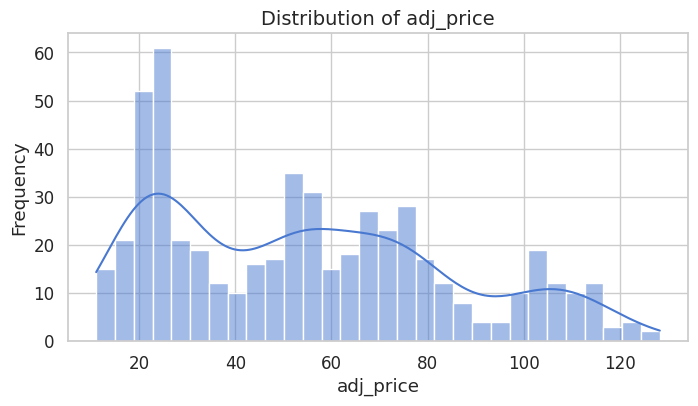

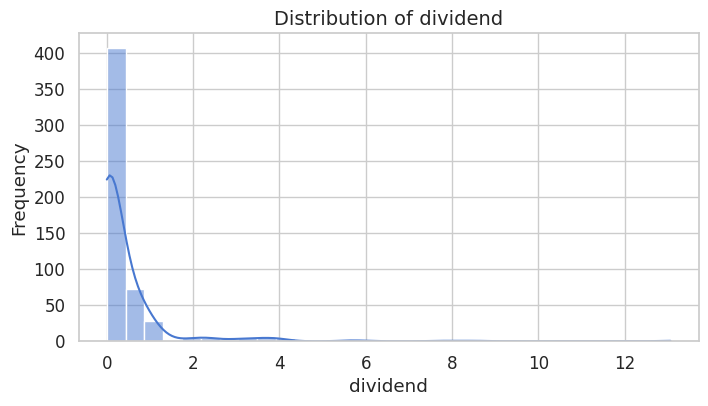

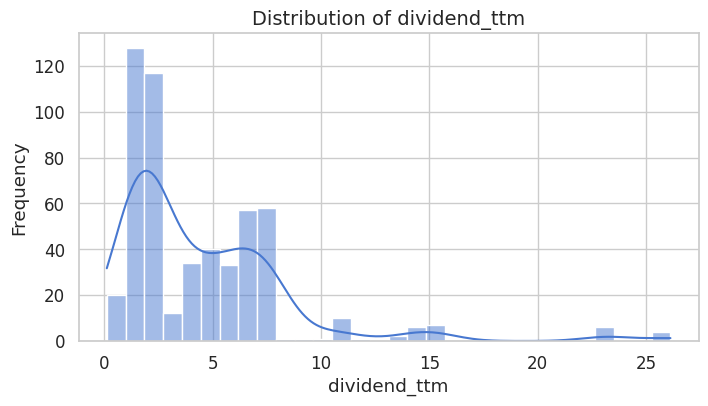

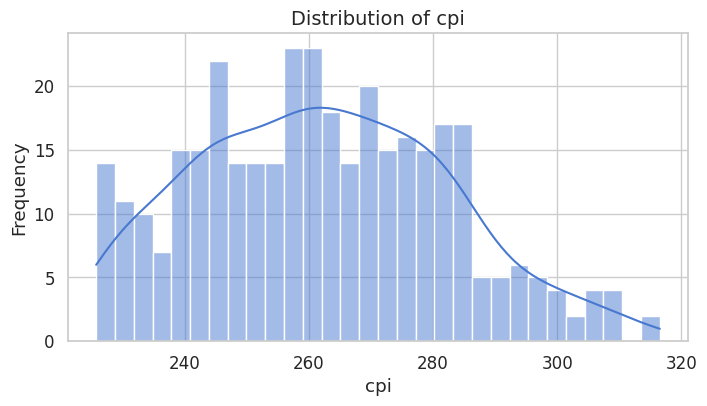

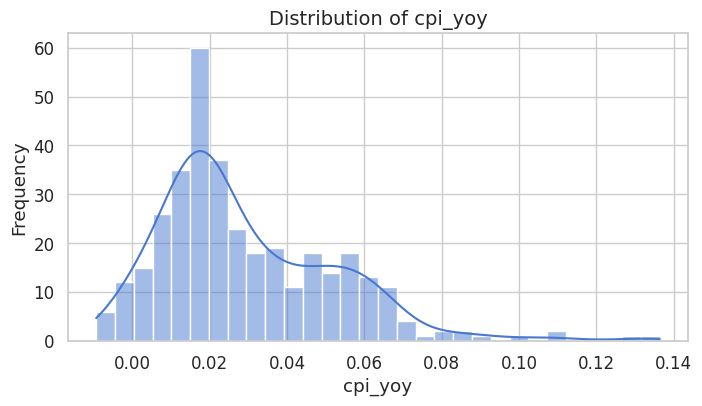

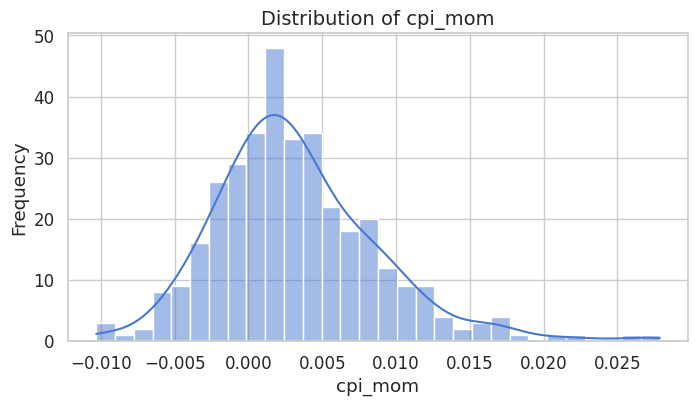

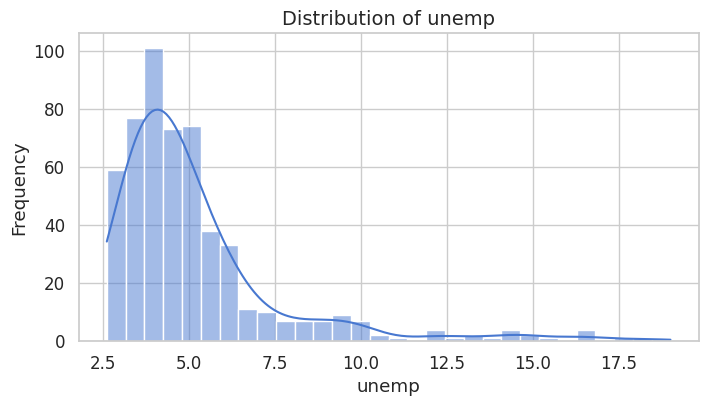

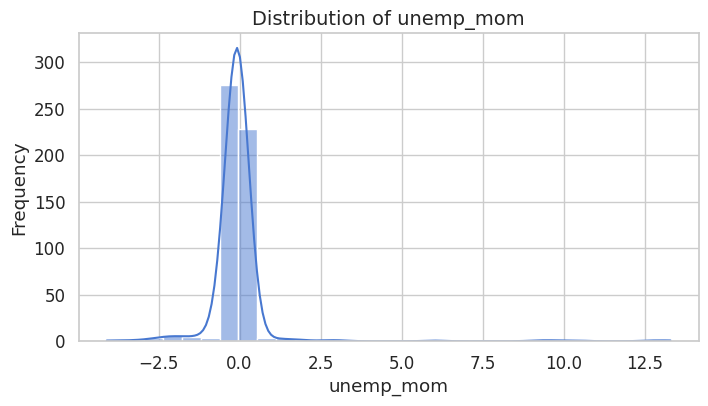

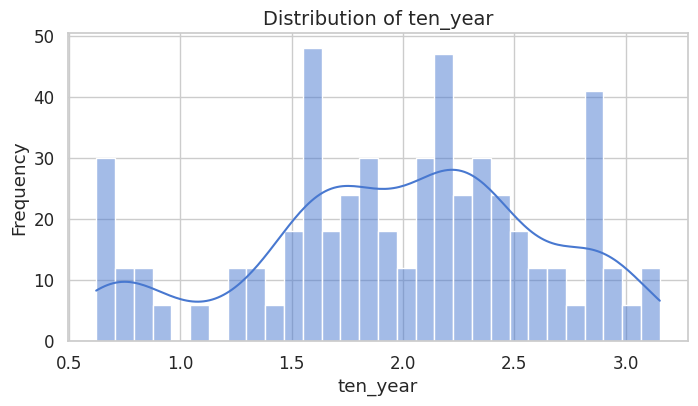

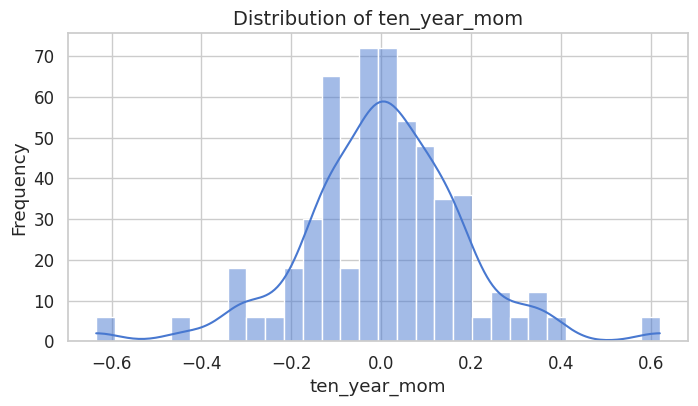

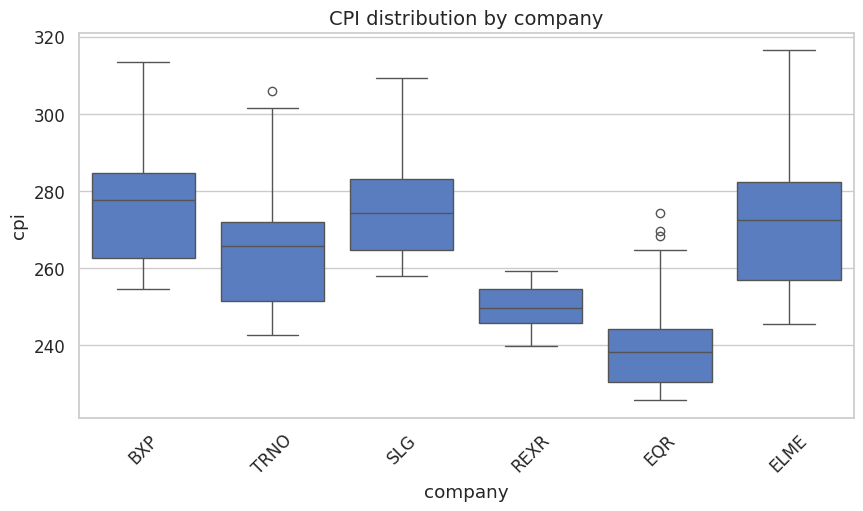

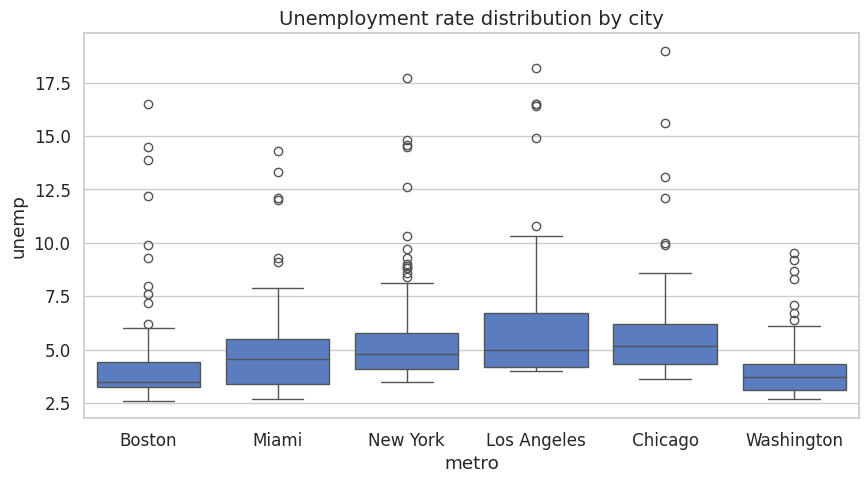

In [ ]:
# Step 3.2: Variable distribution visualization (Training set)

import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Select numerical features (excluding date and categorical variables)
num_cols = train_df.select_dtypes(include=["float64", "int64"]).columns

print("Numerical variables:", num_cols.tolist())

# 1. Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# 2. Comparison across companies/regions (using CPI as an example)
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="company", y="cpi")
plt.title("CPI distribution by company", fontsize=14)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="metro", y="unemp")
plt.title("Unemployment rate distribution by city", fontsize=14)
plt.show()


Calculate the correlation between numerical variables and plot a heatmap.
Explore linear relationships among variables to determine if multicollinearity exists.

Correlation matrix of numerical variables:


,adj_price,dividend,dividend_ttm,cpi,cpi_yoy,cpi_mom,unemp,unemp_mom,ten_year,ten_year_mom
adj_price,1.000000,0.196598,0.524375,0.262500,0.038913,0.052025,-0.102272,-0.010750,-0.002515,0.045657
dividend,0.196598,1.000000,0.287565,-0.012953,-0.083534,0.074500,-0.017832,-0.020127,-0.004540,-0.041438
dividend_ttm,0.524375,0.287565,1.000000,-0.035349,-0.185490,-0.059667,0.031208,-0.006864,-0.059679,0.038203
cpi,0.262500,-0.012953,-0.035349,1.000000,0.616430,0.362379,-0.048867,-0.034361,-0.168095,0.139841
cpi_yoy,0.038913,-0.083534,-0.185490,0.616430,1.000000,0.535181,-0.348630,-0.056443,0.148846,0.206491
cpi_mom,0.052025,0.074500,-0.059667,0.362379,0.535181,1.000000,-0.173192,-0.219157,0.038487,0.280047
unemp,-0.102272,-0.017832,0.031208,-0.048867,-0.348630,-0.173192,1.000000,0.238383,-0.659873,0.001334
unemp_mom,-0.010750,-0.020127,-0.006864,-0.034361,-0.056443,-0.219157,0.238383,1.000000,-0.074781,-0.185382
ten_year,-0.002515,-0.004540,-0.059679,-0.168095,0.148846,0.038487,-0.659873,-0.074781,1.000000,0.174271
ten_year_mom,0.045657,-0.041438,0.038203,0.139841,0.206491,0.280047,0.001334,-0.185382,0.174271,1.000000


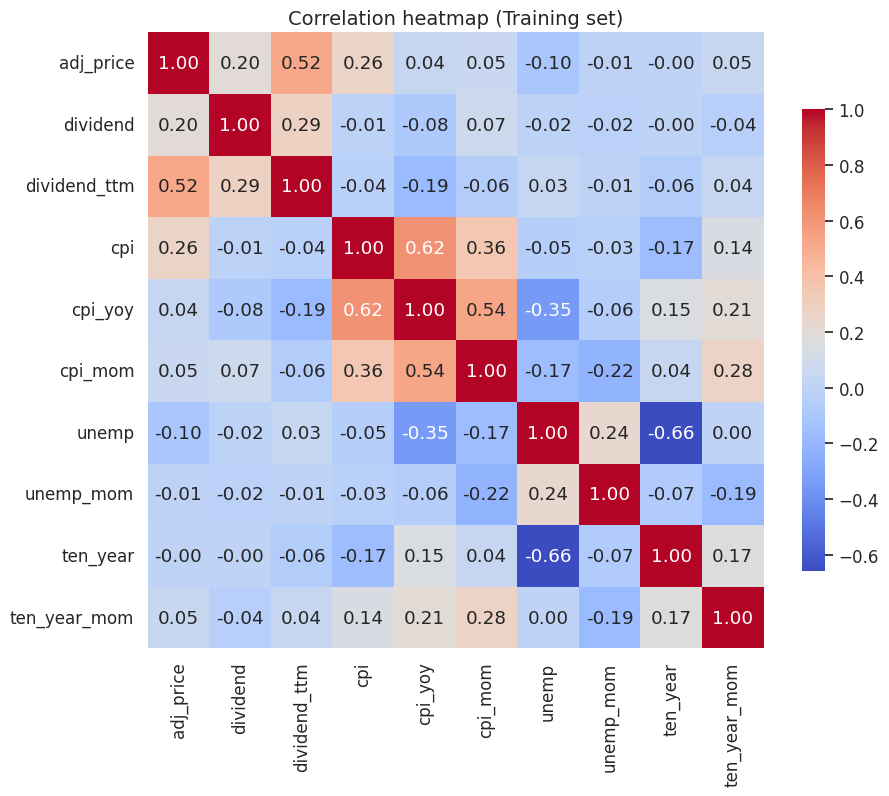

In [ ]:
# Step 3.3: Correlation analysis (Training set)

# Select only numerical features
num_cols = train_df.select_dtypes(include=["float64", "int64"]).columns

# Compute Pearson correlation coefficients
corr_matrix = train_df[num_cols].corr(method="pearson")

print("Correlation matrix of numerical variables:")
display(corr_matrix)

# Visualize as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation heatmap (Training set)", fontsize=14)
plt.show()



# Week4: Make Data Model Ready

In [ ]:
# Step 1: Missing Value Handling

# Backup the data
df_clean = df_merged.copy()

num_cols = ["cpi", "cpi_yoy", "cpi_mom", "unemp", "unemp_mom"]
for col in num_cols:
    df_clean[col] = (df_clean
                     .sort_values(["metro","date"])
                     .groupby("metro")[col]
                     .ffill())

medians = df_clean[num_cols].median()
df_clean[num_cols] = df_clean[num_cols].fillna(medians)

print("Missing value check: after")
print(df_clean.isna().sum())

# Save the cleaned data
df_clean.to_csv(OUT_DIR / "week4_step1_missing_cleaned.csv", index=False)
print("Cleaned data saved")


Missing value check: after
date            0
company         0
adj_price       0
dividend        0
dividend_ttm    0
metro           0
cpi             0
cpi_yoy         0
cpi_mom         0
unemp           0
unemp_mom       0
ten_year        0
ten_year_mom    0
dtype: int64
Cleaned data saved


In [ ]:
# Step 2: Outlier Handling

df_outlier = df_clean.copy()

# Trimming
df_outlier["unemp"] = df_outlier["unemp"].clip(lower=0, upper=25)
df_outlier["ten_year"] = df_outlier["ten_year"].clip(lower=0, upper=15)
df_outlier["dividend_ttm"] = df_outlier["dividend_ttm"].clip(lower=0, upper=df_outlier["dividend_ttm"].quantile(0.99))

# IQR-based winsorization
def winsorize_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower=lower, upper=upper)

for col in ["cpi_mom", "cpi_yoy", "unemp_mom", "ten_year_mom"]:
    df_outlier[col] = winsorize_iqr(df_outlier[col])

# Check again
print("Statistics after outlier handling")
print(df_outlier[["unemp","ten_year","dividend_ttm","cpi_mom","cpi_yoy","unemp_mom","ten_year_mom"]].describe().T)

# Save the results
df_outlier.to_csv(OUT_DIR / "week4_step2_outlier_cleaned.csv", index=False)
print("Outlier handling saved")


Statistics after outlier handling
              count      mean       std       min       25%       50%  \
unemp         769.0  4.774902  2.302299  2.400000  3.500000  4.300000   
ten_year      769.0  2.589282  1.107689  0.623636  1.764500  2.360000   
dividend_ttm  769.0  4.525647  3.544490  0.120000  1.910000  3.640000   
cpi_mom       769.0  0.003601  0.005426 -0.009567  0.000328  0.002349   
cpi_yoy       769.0  0.044517  0.030260 -0.009328  0.022217  0.036097   
unemp_mom     769.0 -0.051235  0.106930 -0.250000 -0.100000  0.000000   
ten_year_mom  769.0  0.015274  0.192864 -0.480238 -0.105238  0.001826   

                   75%        max  
unemp         5.100000  19.000000  
ten_year      3.573636   4.798095  
dividend_ttm  6.462500  23.176400  
cpi_mom       0.006925   0.016820  
cpi_yoy       0.058835   0.113761  
unemp_mom     0.000000   0.150000  
ten_year_mom  0.144762   0.519762  
Outlier handling saved


In [ ]:
# Step 3: Variable Transformation and Standardization

from sklearn.preprocessing import StandardScaler
import joblib

df_trans = df_outlier.copy()

# Log transformation
df_trans["adj_price_log"] = np.log1p(df_trans["adj_price"])
df_trans["dividend_ttm_log"] = np.log1p(df_trans["dividend_ttm"])

# Standardization
scale_cols = [
    "cpi", "cpi_yoy", "cpi_mom",
    "unemp", "unemp_mom",
    "ten_year", "ten_year_mom",
    "adj_price_log", "dividend_ttm_log"
]

scaler = StandardScaler()
df_trans_scaled = df_trans.copy()
df_trans_scaled[scale_cols] = scaler.fit_transform(df_trans[scale_cols])

# Save model
joblib.dump(scaler, OUT_DIR / "week4_step3_scaler.pkl")

# Check standardized results
print("Statistics after standardization")
print(df_trans_scaled[scale_cols].describe().T[["mean", "std"]])

# Save data
df_trans_scaled.to_csv(OUT_DIR / "week4_step3_transformed.csv", index=False)
print("variable transformation and standardization saved")


Statistics after standardization
                          mean       std
cpi              -1.191938e-15  1.000651
cpi_yoy           4.619914e-17  1.000651
cpi_mom           9.239828e-18  1.000651
unemp            -2.125160e-16  1.000651
unemp_mom         9.701819e-17  1.000651
ten_year          8.777836e-17  1.000651
ten_year_mom      9.239828e-18  1.000651
adj_price_log    -1.293576e-16  1.000651
dividend_ttm_log -4.250321e-16  1.000651
variable transformation and standardization saved


In [ ]:
# Step 4: Remove Unnecessary or Redundant Variables

df_final = df_trans_scaled.copy()

# Drop unnecessary variables
drop_cols = ["adj_price", "dividend", "dividend_ttm"]
df_final = df_final.drop(columns=drop_cols, errors="ignore")

print("Remaining variables:")
print(df_final.columns.tolist())

# Save data
df_final.to_csv(OUT_DIR / "week4_step4_feature_selected.csv", index=False)
print("saved")


Remaining variables:
['date', 'company', 'metro', 'cpi', 'cpi_yoy', 'cpi_mom', 'unemp', 'unemp_mom', 'ten_year', 'ten_year_mom', 'adj_price_log', 'dividend_ttm_log']
saved


In [ ]:
# Step 5: Categorical Variable Encoding

df_encoded = df_final.copy()

# One-Hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns=["company", "metro"], drop_first=False)

print("One-Hot Encoding")
print(df_encoded.columns.tolist())

# Save the result
df_encoded.to_csv(OUT_DIR / "week4_step5_encoded.csv", index=False)
print("saved")


One-Hot Encoding
['date', 'cpi', 'cpi_yoy', 'cpi_mom', 'unemp', 'unemp_mom', 'ten_year', 'ten_year_mom', 'adj_price_log', 'dividend_ttm_log', 'company_BXP', 'company_ELME', 'company_EQR', 'company_REXR', 'company_SLG', 'company_TRNO', 'metro_Boston', 'metro_Chicago', 'metro_Los Angeles', 'metro_Miami', 'metro_New York', 'metro_Washington']
saved


In [ ]:
# Step 6: Bucketize
# Step X: Bucketize / Categorize selected numerical variables

df_bucket = df_encoded.copy()

# Example 1: Bucketize 'ten_year' into 3 quantile-based bins
df_bucket["ten_year_bin"] = pd.qcut(
    df_bucket["ten_year"],
    q=3,
    labels=["low", "mid", "high"]
)

# Example 2: Bucketize 'cpi_yoy' into 4 quantile-based bins
df_bucket["cpi_yoy_bin"] = pd.qcut(
    df_bucket["cpi_yoy"],
    q=4,
    labels=["Q1_lowest", "Q2", "Q3", "Q4_highest"]
)

# One-hot encode the new categorical bins
df_bucket = pd.get_dummies(
    df_bucket,
    columns=["ten_year_bin", "cpi_yoy_bin"],
    drop_first=False
)

print("Bucketized and encoded columns added:")
print(df_bucket.filter(like="ten_year_bin").head())
print(df_bucket.filter(like="cpi_yoy_bin").head())

# Save the bucketized dataset
df_bucket.to_csv(OUT_DIR / "week4_step_bucketized.csv", index=False)
print("Bucketized dataset saved.")


Bucketized and encoded columns added:
   ten_year_bin_low  ten_year_bin_mid  ten_year_bin_high  ten_year_bin_low  \
0             False              True              False             False   
1              True             False              False              True   
2              True             False              False              True   
3             False              True              False             False   
4              True             False              False              True   

   ten_year_bin_mid  ten_year_bin_high  
0              True              False  
1             False              False  
2             False              False  
3              True              False  
4             False              False  
   cpi_yoy_bin_Q1_lowest  cpi_yoy_bin_Q2  cpi_yoy_bin_Q3  \
0                  False            True           False   
1                   True           False           False   
2                   True           False           False   
3      

In [ ]:
# Step 7: Final Check and Export
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#Split the dataset chronologically to avoid future information leakage
df_final = df_outlier.copy().sort_values("date").reset_index(drop=True)

n = len(df_final)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

train_df = df_final.iloc[:train_end].copy()
valid_df = df_final.iloc[train_end:valid_end].copy()
test_df  = df_final.iloc[valid_end:].copy()

print("Dataset split results (before transformation)")
print(f"Train: {train_df.shape}, {train_df['date'].min()} → {train_df['date'].max()}")
print(f"Valid: {valid_df.shape}, {valid_df['date'].min()} → {valid_df['date'].max()}")
print(f"Test : {test_df.shape}, {test_df['date'].min()} → {test_df['date'].max()}")

#Define numerical and categorical variables
num_cols = [
    "cpi", "cpi_yoy", "cpi_mom",
    "unemp", "unemp_mom",
    "ten_year", "ten_year_mom"
]

cat_cols = ["company", "metro"]

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="drop"
)

# 4Fit on the training set, then transform validation and test sets
X_train = preprocessor.fit_transform(train_df)
X_valid = preprocessor.transform(valid_df)
X_test  = preprocessor.transform(test_df)

# Convert back to DataFrame with feature names
num_features = [f"z_{c}" for c in num_cols]
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist()
feature_names = num_features + cat_features

train_final = pd.DataFrame(X_train, columns=feature_names, index=train_df.index)
valid_final = pd.DataFrame(X_valid, columns=feature_names, index=valid_df.index)
test_final  = pd.DataFrame(X_test,  columns=feature_names, index=test_df.index)

# Final quality checks: missing values and duplicates
print("\nMissing values check:")
print("train:", train_final.isna().sum().sum(),
      "valid:", valid_final.isna().sum().sum(),
      "test:", test_final.isna().sum().sum())

print("\nDuplicate rows check:")
print("train:", train_final.duplicated().sum(),
      "valid:", valid_final.duplicated().sum(),
      "test:", test_final.duplicated().sum())

# Save final datasets
train_final.to_csv(OUT_DIR / "week4_train.csv", index=False)
valid_final.to_csv(OUT_DIR / "week4_valid.csv", index=False)
test_final.to_csv(OUT_DIR / "week4_test.csv", index=False)
print("Final datasets saved (train/valid/test)")


Dataset split results (before transformation)
Train: (538, 13), 2014-12-31 00:00:00 → 2022-05-31 00:00:00
Valid: (115, 13), 2022-05-31 00:00:00 → 2023-12-31 00:00:00
Test : (116, 13), 2024-01-31 00:00:00 → 2025-08-31 00:00:00

Missing values check:
train: 0 valid: 0 test: 0

Duplicate rows check:
train: 0 valid: 0 test: 0
Final datasets saved (train/valid/test)
